In [1]:
%matplotlib inline

import os
import numpy as np
import pandas

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap

from datetime import datetime, timedelta
from scipy import stats

import xarray as xr

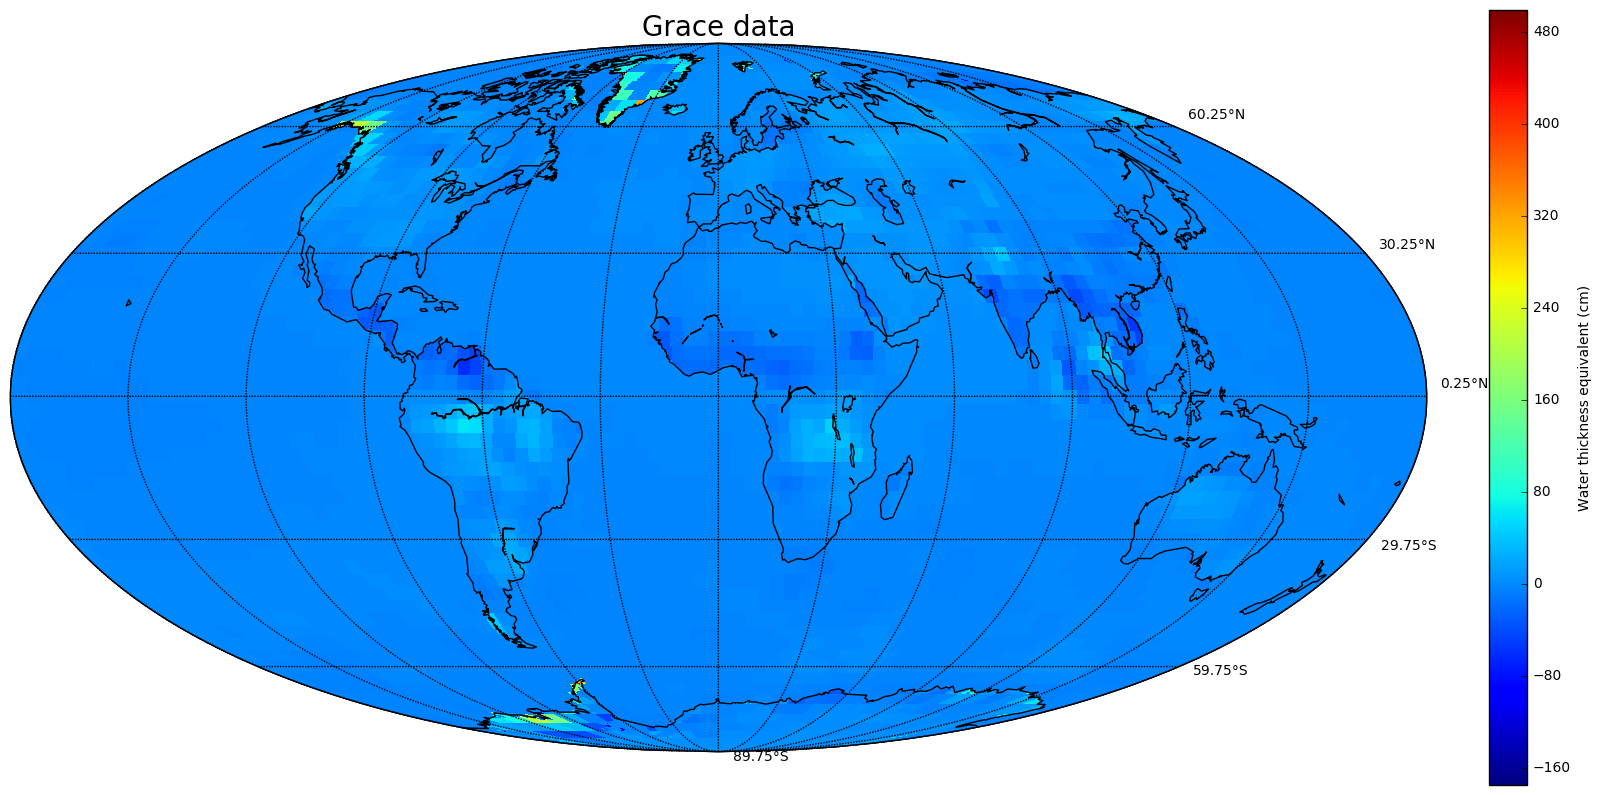

In [2]:
#url = 'http://opendap.jpl.nasa.gov:80/opendap/GeodeticsGravity/tellus/L3/land_mass/RL05/netcdf/GRCTellus.JPL.200204_201607.LND.RL05_1.DSTvSCS1411.nc'
nc = 'http://opendap.jpl.nasa.gov:80/opendap/GeodeticsGravity/tellus/L3/mascon/RL05/JPL/CRI/netcdf/GRCTellus.JPL.200204_201606.GLO.RL05M_1.MSCNv02CRIv02.nc'
data = xr.open_dataset(nc)
rmap = data['lwe_thickness'][0,:,:]

# Extract Lat/Lon Metadata
lat_min = data.geospatial_lat_min
lat_max = data.geospatial_lat_max
lat_res = float(data.geospatial_lat_resolution[0:3])

lon_min = data.geospatial_lon_min
lon_max = data.geospatial_lon_max
lon_res = float(data.geospatial_lon_resolution[0:3])

# Build grid
lon_g = np.arange(lon_min,lon_max+lon_res,lon_res)
lat_g = np.arange(lat_min,lat_max+lat_res,lat_res)
x,y = np.meshgrid(lon_g[:], lat_g[:])

# Plot Fig
plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw parallels and meridians.
parallels = np.arange(-89.75,89.75,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

ax = plt.gca()
masked_array = np.ma.array(rmap, mask=np.isnan(rmap))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,rmap,shading='flat',latlon=True);
im2 = m.pcolormesh(x,y,masked_array,shading='flat',latlon=True)
m.drawcoastlines();
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Water thickness equivalent (cm)')
plt.title('Grace data',size=20)


In [3]:
# use pd.read_csv to read in the csv data
csv = 'https://www.hydroshare.org/django_irods/download/d3659dcf575d4090801a74d1ce096d7c/data/contents/WPDx_Well_Function_Upd_151224_xy161117.csv'
wells = pd.read_csv(csv)

In [ ]:
# 1. Code that subselects regions of interest. This is for all of Africa, but could be used later to get individual time series

data = xr.open_dataset('http://opendap.jpl.nasa.gov:80/opendap/GeodeticsGravity/tellus/L3/mascon/RL05/JPL/CRI/netcdf/GRCTellus.JPL.200204_201606.GLO.RL05M_1.MSCNv02CRIv02.nc')
test = data['lwe_thickness'].isel(time=0).sel(lat=slice(-37.75,37.75)).sel(lon=slice(340.25,359.75)).sel(lon=slice(0.25,50.75))
lonAF = data['lon'].sel(lon=slice(340.25,359.75)).sel(lon=slice(0.25,50.75))
latAF = data['lat'].sel(lat=slice(-37.75,37.75))
#lonAF = data['lon'].sel(lon=slice(-18.75,50.75))
#roll?

In [ ]:
# Find nearest grid locations for all data
# lon_g and lat_g are the lons and lats of the gridded products, respectively

lon_g = np.linspace(0,360,num=360/xRes +1)
lat_g = np.linspace(-90,90,num=180/yRes +1)

# Define grid box centers
lon_c = lon_g[:-1]+xRes/2
lat_c = lat_g[:-1]+yRes/2

# Define a new metadata file that has grid coordinates for this resolution choice
pmg = pm;

pmg.loc[:,'lat_ind'] = np.nan
pmg.loc[:,'lon_ind'] = np.nan

## Determine lat_ind and lon_ind for every record

# List of proxy sites
#site_list = list(proxy_data.columns.values)
site_list = list(pn.columns.values)

for index, row in pmg.iterrows():
    lon_s = row['Lon_E']
    lat_s = row['Lat_N']
    lat_ind = np.digitize(lat_s,lat_g,right=True)
    lon_ind = np.digitize(lon_s,lon_g,right=True)
    pmg.set_value(index,'lat_ind',lat_ind-1)
    pmg.set_value(index,'lon_ind',lon_ind-1)